In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models for Regression
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_squared_log_error,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Other machine learning libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Preprocessing and pipelines
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [9]:
#Importing dataset
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv',parse_dates =['date'])
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv',parse_dates =['date'])

In [10]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,date,country,store,product,num_sold
0,0,2010-01-01 00:00:00,Canada,Discount Stickers,Holographic Goose,nan
1,1,2010-01-01 00:00:00,Canada,Discount Stickers,Kaggle,973.00
2,2,2010-01-01 00:00:00,Canada,Discount Stickers,Kaggle Tiers,906.00
3,3,2010-01-01 00:00:00,Canada,Discount Stickers,Kerneler,423.00
4,4,2010-01-01 00:00:00,Canada,Discount Stickers,Kerneler Dark Mode,491.00


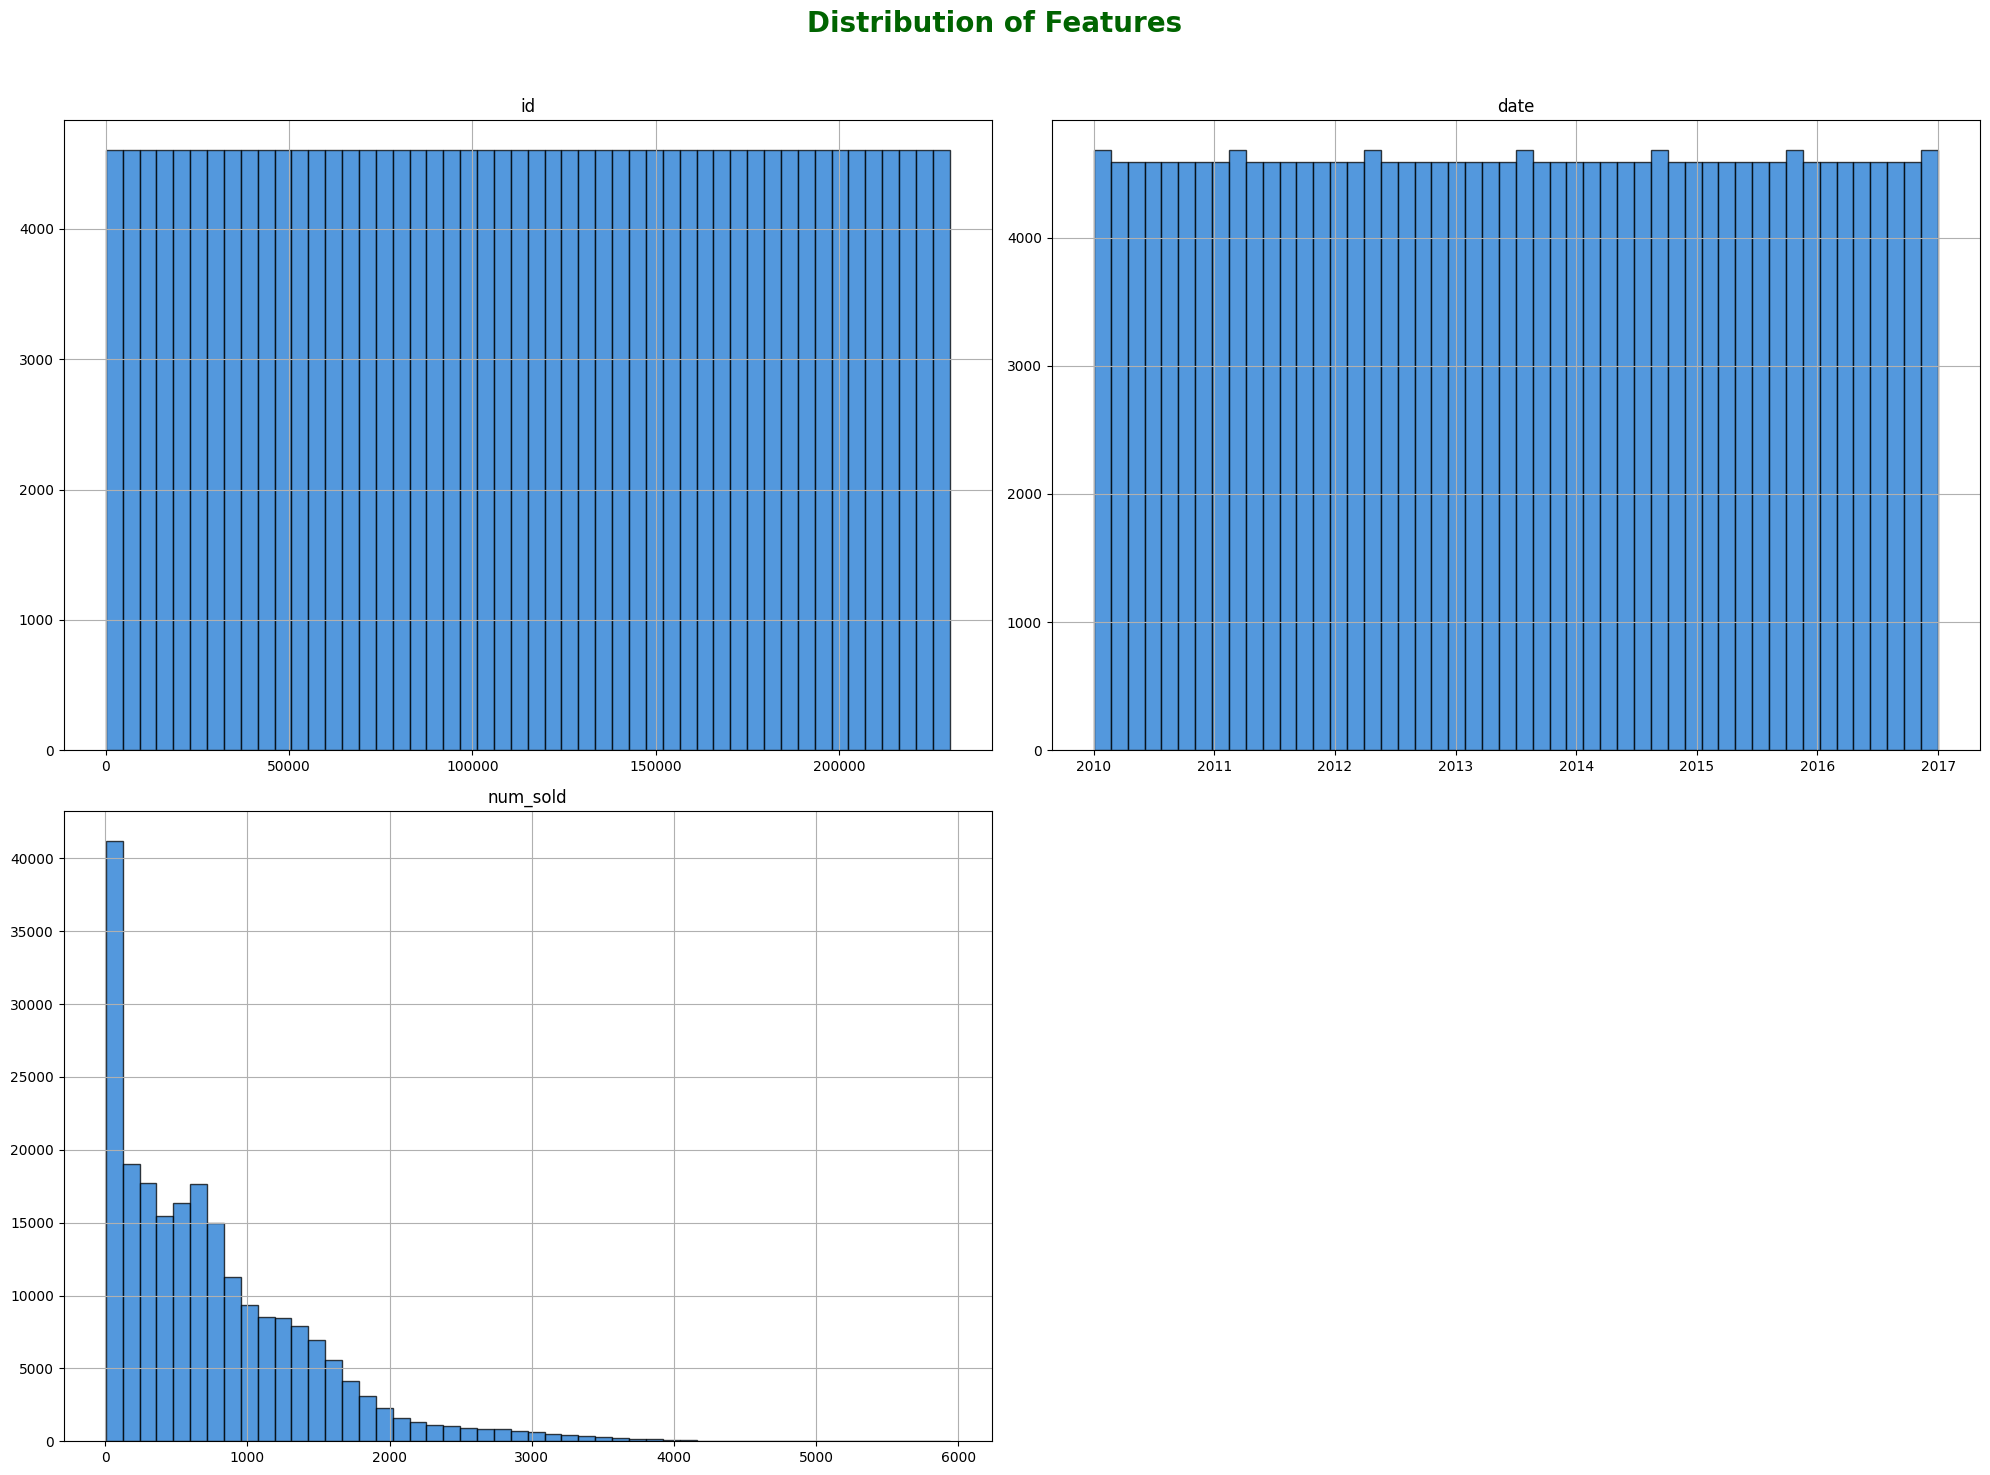

In [11]:
train.hist(
    bins=50, 
    figsize=(20, 15), 
    color='#1976d2', 
    edgecolor='black',
    alpha=0.75
)

# Add global title and adjust layout
plt.suptitle("Distribution of Features", fontsize=20, fontweight='bold', color='darkgreen')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
#For numerical variables, we can use the describe method to understand the value range and identify outliers.
train.describe().style.format(precision=2).background_gradient(cmap="Blues")

,id,date,num_sold
count,230130.00,230130,221259.00
mean,115064.50,2013-07-02 00:00:00,752.53
min,0.00,2010-01-01 00:00:00,5.00
25%,57532.25,2011-10-02 00:00:00,219.00
50%,115064.50,2013-07-02 00:00:00,605.00
75%,172596.75,2015-04-02 00:00:00,1114.00
max,230129.00,2016-12-31 00:00:00,5939.00
std,66432.95,nan,690.17


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        221259 non-null  int64         
 1   date      221259 non-null  datetime64[ns]
 2   country   221259 non-null  object        
 3   store     221259 non-null  object        
 4   product   221259 non-null  object        
 5   num_sold  221259 non-null  float64       
 6   day       221259 non-null  int32         
 7   month     221259 non-null  int32         
 8   year      221259 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(1), object(3)
memory usage: 14.3+ MB


In [39]:
#Dropping rows where num_sold is null
train = train.dropna(subset=['num_sold'])

In [40]:
#Train data
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year 

#Test data
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year 

In [41]:
y = train['num_sold']
X = train.drop(columns=['num_sold','date'])

In [42]:
# Separating numerical and object columns 
def separate_columns(df):
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    num_col = [col for col in df.columns if df[col].dtype != 'object']
    return cat_col, num_col

cat_col, num_col = separate_columns(X)

print('Categorical datatype columns include: \n', cat_col)
print('Numerical datatype columns include: \n', num_col)


Categorical datatype columns include: 
 ['country', 'store', 'product']
Numerical datatype columns include: 
 ['id', 'day', 'month', 'year']


In [43]:
# Numerical pipeline
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# Categorical pipeline
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

In [44]:
# Combine them using ColumnTransformer
def create_preprocessor(numerical_pipeline, categorical_pipeline, num_col, cat_col):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_col),
            ('cat', categorical_pipeline, cat_col)
        ]
    )
    return preprocessor

# Create the preprocessor using the function
preprocessor = create_preprocessor(numerical_pipeline, categorical_pipeline, num_col, cat_col)

# Apply preprocessing to the training 
train_temp = preprocessor.fit_transform(X)
test_temp = preprocessor.fit_transform(test)


In [45]:
X_train,X_test,y_train,y_test = train_test_split(train_temp,y,test_size=0.2,random_state=21)

In [46]:
models = {
    "AdaBoost": AdaBoostRegressor(),
    "Bagging": BaggingRegressor(),
    "RandomForest": RandomForestRegressor()
}

In [47]:
# Iterate over the models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE for {model_name}: {rmsle}")


Training AdaBoost...
RMSLE for AdaBoost: 1.3472866929400662
Training Bagging...
RMSLE for Bagging: 0.1015247331878237
Training RandomForest...
RMSLE for RandomForest: 0.09828056355027133


In [50]:
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
y_final = model1.predict(test_temp)


In [54]:
test['Predicted_Value'] = y_final
result_df = pd.DataFrame({
    'id': test['id'],
    'num_sold': y_final
})
print(result_df)
result_df.to_csv("submission.csv", index=False)


           id  num_sold
0      230130    121.98
1      230131    706.72
2      230132    626.07
3      230133    373.74
4      230134    431.13
...       ...       ...
98545  328675    439.80
98546  328676   2841.17
98547  328677   2219.98
98548  328678   1172.81
98549  328679   1525.45

[98550 rows x 2 columns]
